<a href="https://colab.research.google.com/github/mbk-dev/publications_RUS/blob/main/11%20compare_CAGR_of_assets.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

Статья [Сравнение доходности активов за 2021 год](https://rostsber.ru/publish/stocks/returns2021.html) на блоге "Рост Сбережений"

In [1]:
# !pip install okama

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12.0, 6.0]

import okama as ok

ok.__version__

'1.3.2'

## Активы

### Классы

In [42]:
ls_classes = [
    'MCFTR.INDX',
    'RGBITR.INDX',
    'RUCBTRNS.INDX',
    'SP500TR.INDX',
    'GC.COMM',
]
 
lg_classes = [
    "ОФЗ",
    "Корпоративные облигации",
    "Акции США",
    "Золото"
]

In [39]:
cl = ok.AssetList(ls_classes, ccy='RUB', inflation=False)
cl

assets           [MCFTR.INDX, RGBITR.INDX, RUCBTRNS.INDX, SP500...
currency                                                       RUB
first_date                                                 2003-01
last_date                                                  2023-12
period_length                                   21 years, 0 months
inflation                                                     None
dtype: object

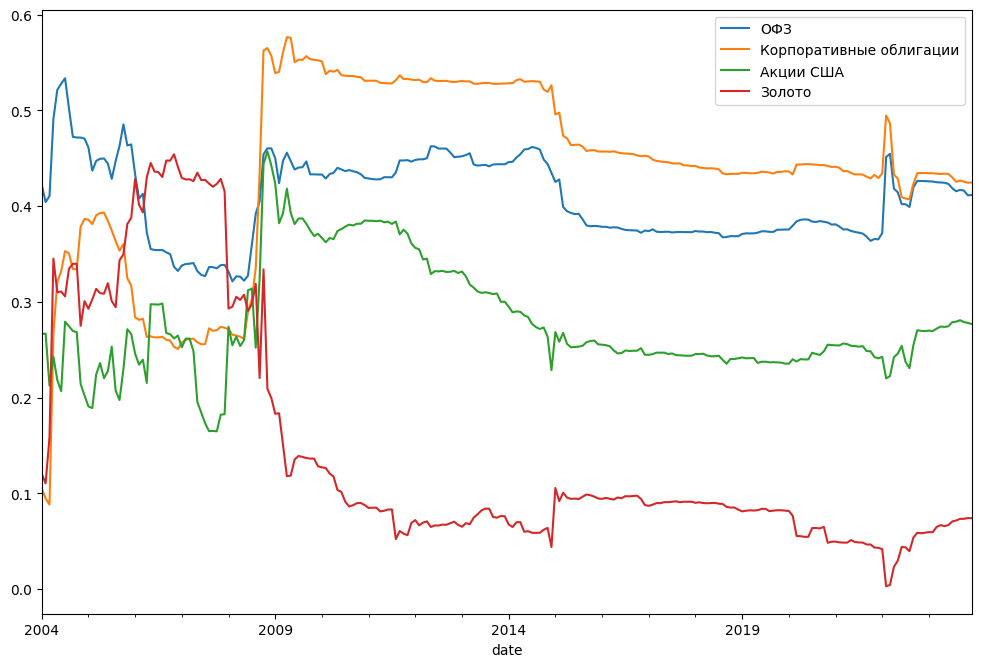

In [43]:
cl.index_corr().plot()
plt.legend(lg_classes)

Text(0.5, 1.0, 'Долгосрочная корреляция между активами. Скользящая 10 лет')

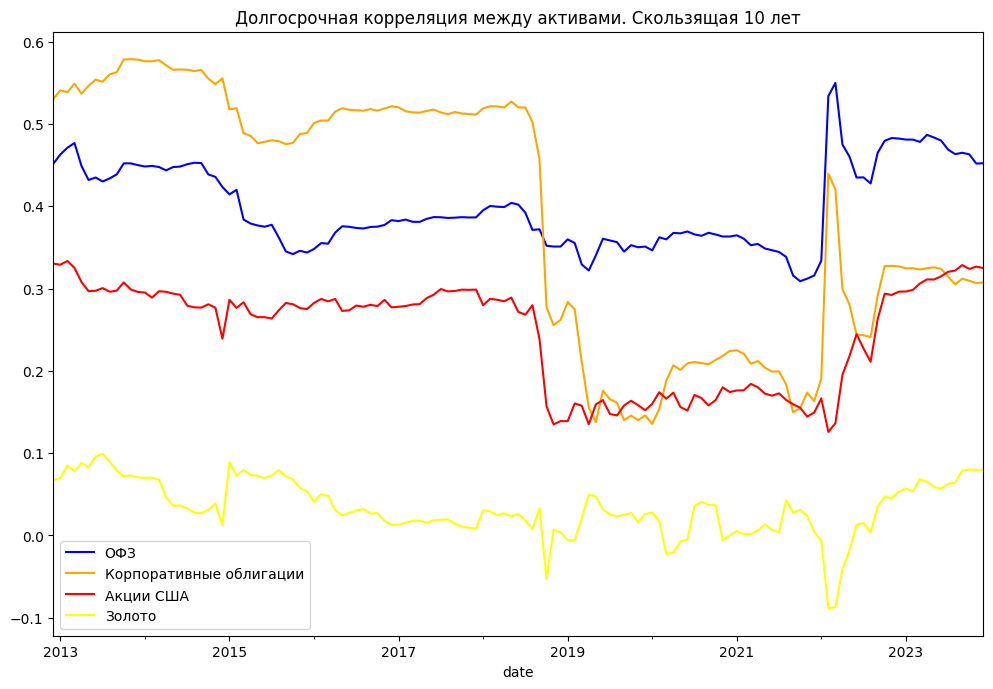

In [47]:
cl.index_corr(rolling_window=12*10).plot(color=["blue", "orange", "red", "yellow"])
plt.legend(lg_classes)
plt.title("Долгосрочная корреляция между активами. Скользящая 10 лет")

### 2003 для 20+ лет

In [3]:
ls_2003 = [
    'RGBITR.INDX',
    'RUCBTRNS.INDX',
    'MCFTR.INDX',
    'SP500TR.INDX',
    # 'IDCOTCTR.INDX',  # US Treasuries
    'SP500BDT.INDX',  # US bonds
    'FNER.INDX',  # REITS
    'MOW_SEC.RE',
    'GC.COMM',
    'SI.COMM',
    'USDRUB.FX',
    'EURRUB.FX',
    'CNYRUB.FX'
]
len(ls_2003)

12

In [4]:
lg_2003 = {
    'RGBITR.INDX': 'Облигации федерального займа РФ (Индекс RGBI)',
    'RUCBTRNS.INDX': 'Корпоративные облигации РФ (индекс RUCBTRNS)',
    'MCFTR.INDX': 'Акции РФ (Индекс Мосбиржи)',
    'SP500TR.INDX': 'Акции США (Индекс S&P 500)',
    # 'IDCOTCTR.INDX': 'Казначейские облигации США (Индекс ICE U.S Treasury Core Bond)',
    'SP500BDT.INDX': 'Корпоративные облигации США (Индекс S&P 500 bonds)',
    'FNER.INDX': 'Недвижимость США (Индекс REIT)',
    'MOW_SEC.RE': 'Недвижимость Москвы (цена кв. метра)',  # раз в квартал 
    'GC.COMM': 'Золото (цены спот)',
    'SI.COMM': 'Серебро (цены спот)',
    'USDRUB.FX': 'Доллар США',
    'EURRUB.FX': 'Евро',
    'CNYRUB.FX': 'Юань',
    'RUB.INFL': 'Инфляция',
}
len(lg_2003)

13

### 2010 для 10+ лет

In [5]:
ls_2010 = ls_2003 + [
    'OKID10.INDX',  # c 2010 года
    'OKID.INDX',  # c 2010 года
]

In [6]:
lg_2010 = {**lg_2003, **{
    'OKID10.INDX': 'Депозиты в рублях TOP10 (индекс OKID 10)',
    'OKID.INDX': 'Депозиты в рублях (индекс OKID)',
}}

### Короткая история

In [7]:
ls_2020 = ls_2010 + [
    'MREDC.INDX',  # c 2010 года
]

In [8]:
lg_2020 = {**lg_2010, **{
    'MREDC.INDX': 'Недвижимость Москвы (индекс MREDC)',
}}

In [9]:
ls_2020

['RGBITR.INDX',
 'RUCBTRNS.INDX',
 'MCFTR.INDX',
 'SP500TR.INDX',
 'SP500BDT.INDX',
 'FNER.INDX',
 'MOW_SEC.RE',
 'GC.COMM',
 'SI.COMM',
 'USDRUB.FX',
 'EURRUB.FX',
 'CNYRUB.FX',
 'OKID10.INDX',
 'OKID.INDX',
 'MREDC.INDX']

## Функция рисования графиков

In [10]:
def plot_cagr(assets: ok.AssetList, legend_dic: dict, plot_title: str):
    fig, ax = plt.subplots(figsize=[12.0, 10.0])
    fig.subplots_adjust(right=1.2)

    inflation = assets.get_cagr().at['RUB.INFL'] * 100
    names = assets.get_cagr().sort_values().index
    width = 0.7  # ширина прямоугольники (в данном случае высота)

    for name in names:
        value = assets.get_cagr().loc[name] * 100
        color = 'grey' if name == 'RUB.INFL' else 'green'
        if 0 <= value < inflation:
            color = 'yellow'
        elif value < 0:
            color = 'red'
        ax.barh(name, value, width, color=color)

    ax.axvline(x=assets.get_cagr().loc["USDRUB.FX"] * 100, linestyle="--")


    # Добавление титула и надписей на оси Y
    x = np.arange(len(names))  # the label locations
    ax.set_title(plot_title)
    ax.set_yticks(x)
    ax.set_yticklabels([legend_dic[x] for x in names])
    # ax.legend()

    # Добавление аннотаций к прямоугольникам
    rects = ax.containers
    for rect in rects:
        width = rect[0].get_width()  # Ширина прямоугольника
        shift = 20 if width >= 0 else -20
        ax.annotate(f'{width:.2f}%',
                    xy=(width, rect[0].get_y() + rect[0].get_height() / 2),
                    # координаты точки, откуда начинается аннотация
                    xytext=(shift, 0),  # смещение надписи вправо
                    textcoords="offset points",
                    ha='center', va='center')
    if any(assets.get_cagr().values < 0):
        ax.axvline(x=0, color='black', linewidth=1)  # вертикальная линия на отметке х=0

## 20 лет

In [11]:
assets20 = ok.AssetList(ls_2003, first_date='2004-01', last_date='2023-12', inflation=True, ccy='RUB')
assets20

assets           [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2004-01
last_date                                                  2023-12
period_length                                   20 years, 0 months
inflation                                                 RUB.INFL
dtype: object

In [12]:
assets20.assets_first_dates

{'SI.COMM': Timestamp('1970-03-01 00:00:00'),
 'FNER.INDX': Timestamp('1972-01-01 00:00:00'),
 'GC.COMM': Timestamp('1975-02-01 00:00:00'),
 'SP500TR.INDX': Timestamp('1988-02-01 00:00:00'),
 'USDRUB.FX': Timestamp('1992-08-01 00:00:00'),
 'CNYRUB.FX': Timestamp('1992-08-01 00:00:00'),
 'RUB': Timestamp('1992-08-01 00:00:00'),
 'SP500BDT.INDX': Timestamp('1995-01-01 00:00:00'),
 'MCFTR.INDX': Timestamp('1997-10-01 00:00:00'),
 'EURRUB.FX': Timestamp('1999-02-01 00:00:00'),
 'MOW_SEC.RE': Timestamp('2000-04-01 00:00:00'),
 'RGBITR.INDX': Timestamp('2003-01-01 00:00:00'),
 'RUCBTRNS.INDX': Timestamp('2003-01-01 00:00:00'),
 'RUB.INFL': Timestamp('1991-01-01 00:00:00')}

In [13]:
assets20.assets_last_dates

{'RUCBTRNS.INDX': Timestamp('2023-12-01 00:00:00'),
 'FNER.INDX': Timestamp('2023-12-01 00:00:00'),
 'MOW_SEC.RE': Timestamp('2023-12-01 00:00:00'),
 'RGBITR.INDX': Timestamp('2024-01-01 00:00:00'),
 'MCFTR.INDX': Timestamp('2024-01-01 00:00:00'),
 'SP500TR.INDX': Timestamp('2024-01-01 00:00:00'),
 'SP500BDT.INDX': Timestamp('2024-01-01 00:00:00'),
 'GC.COMM': Timestamp('2024-01-01 00:00:00'),
 'SI.COMM': Timestamp('2024-01-01 00:00:00'),
 'USDRUB.FX': Timestamp('2024-01-01 00:00:00'),
 'EURRUB.FX': Timestamp('2024-01-01 00:00:00'),
 'CNYRUB.FX': Timestamp('2024-01-01 00:00:00'),
 'RUB': Timestamp('2024-01-01 00:00:00'),
 'RUB.INFL': Timestamp('2023-12-01 00:00:00')}

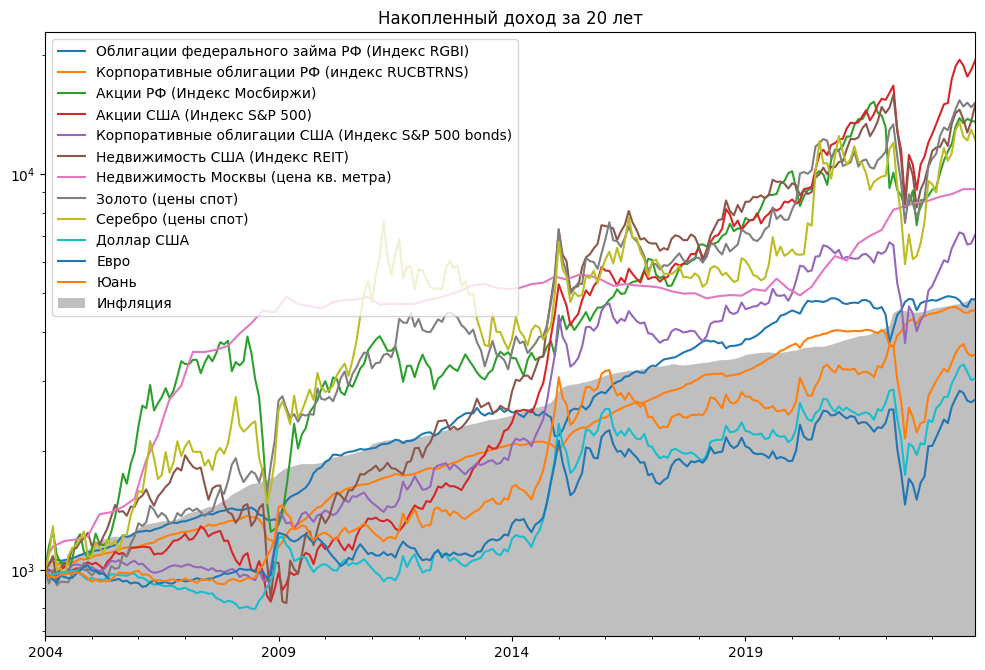

In [14]:
assets20.wealth_indexes.iloc[:, :-1].plot(logy=True)
plt.fill_between(assets20.wealth_indexes.index.to_timestamp(), 0, assets20.wealth_indexes['RUB.INFL'], facecolor='grey', alpha=0.5)
plt.legend(lg_2003.values())
plt.xlabel("")
plt.title('Накопленный доход за 20 лет');

In [15]:
assets20.describe([1, 5, 10, 20])

,property,period,RGBITR.INDX,RUCBTRNS.INDX,MCFTR.INDX,SP500TR.INDX,SP500BDT.INDX,FNER.INDX,MOW_SEC.RE,GC.COMM,SI.COMM,USDRUB.FX,EURRUB.FX,CNYRUB.FX,inflation
0,Compound return,YTD,0.007554,0.024064,0.538714,0.609905,0.382409,0.419593,0.07018,0.451357,0.274347,0.274957,0.31095,0.270956,0.076087
1,CAGR,1 years,0.007554,0.024064,0.538714,0.609905,0.382409,0.419593,0.07018,0.451357,0.274347,0.274957,0.31095,0.270956,0.076087
2,CAGR,5 years,0.053131,0.07592,0.133258,0.217545,0.081698,0.13225,0.132137,0.158996,0.148296,0.052396,0.045293,0.044916,0.071335
3,CAGR,10 years,0.066235,0.081636,0.143696,0.239251,0.14006,0.193991,0.059941,0.167927,0.130141,0.106049,0.082286,0.088321,0.071718
4,CAGR,20 years,0.081868,0.078447,0.139362,0.15979,0.102378,0.144798,0.117222,0.145654,0.133531,0.057265,0.05077,0.064711,0.082426
5,CAGR,"20 years, 0 months",0.081868,0.078447,0.139362,0.15979,0.102378,0.144798,0.117222,0.145654,0.133531,0.057265,0.05077,0.064711,0.082426
6,Dividend yield,LTM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7,Risk,"20 years, 0 months",0.083038,0.050142,0.293829,0.228441,0.201149,0.303035,0.07187,0.276897,0.420948,0.183314,0.176413,0.182361,NaN
8,CVAR,"20 years, 0 months",0.161545,0.125852,0.644897,0.338278,0.347368,0.395392,0.056978,0.257367,0.400735,0.244153,0.341637,0.293521,NaN
9,Max drawdowns,"20 years, 0 months",-0.228385,-0.166086,-0.679146,-0.48951,-0.443925,-0.577167,-0.127073,-0.436844,-0.526212,-0.39155,-0.425154,-0.418448,NaN


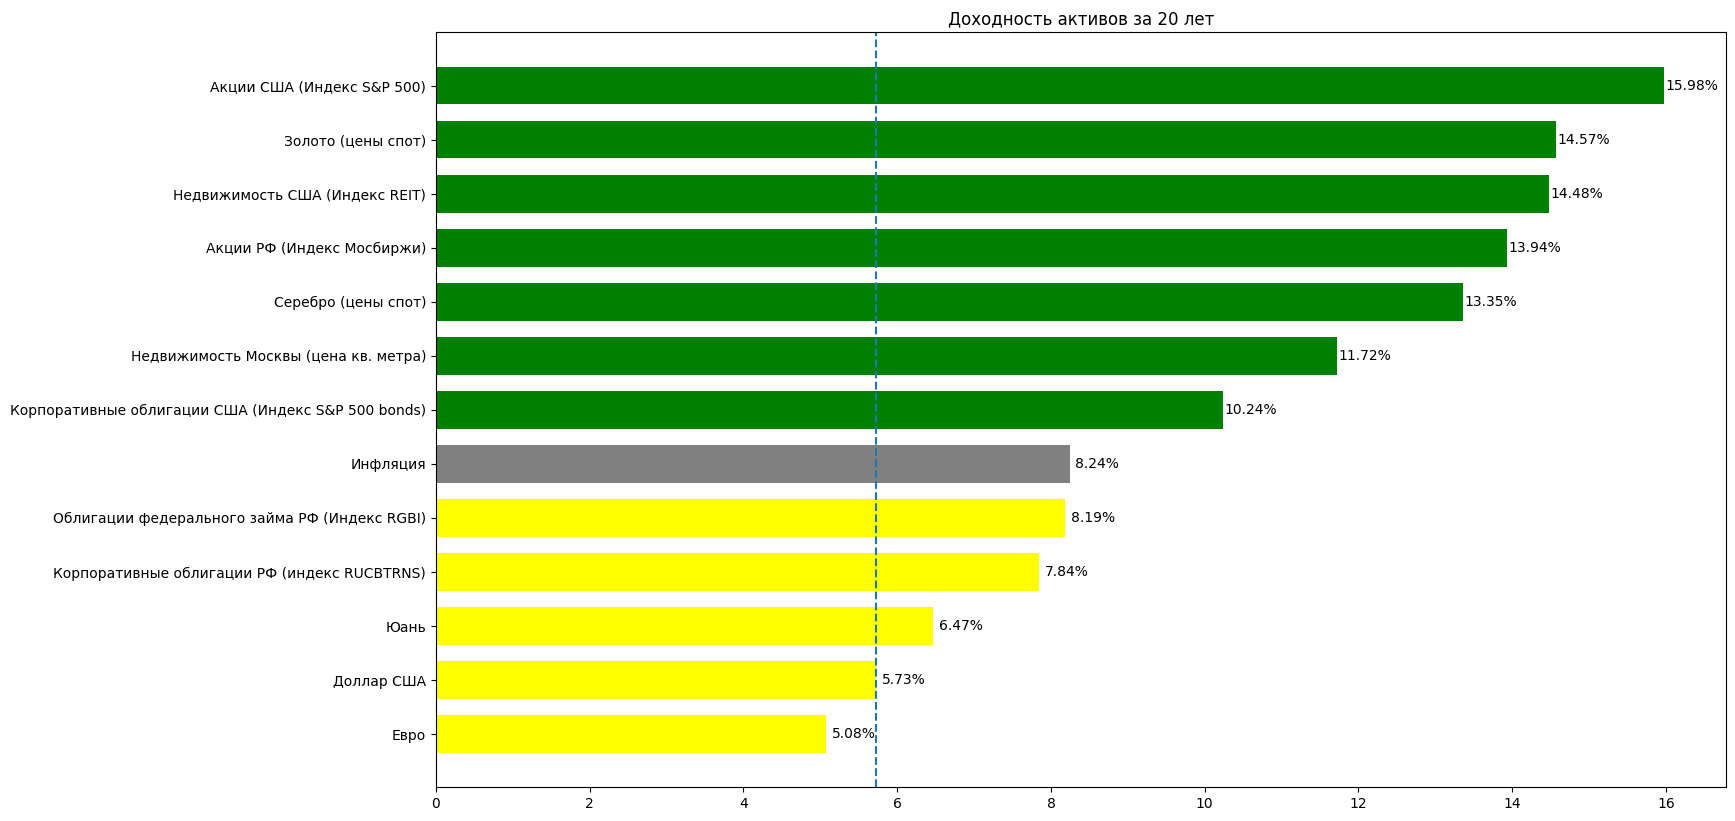

In [16]:
plot_cagr(assets20, lg_2003, 'Доходность активов за 20 лет')

## 10 лет

In [17]:
assets10 = ok.AssetList(ls_2010, first_date='2014-01', last_date='2023-12', ccy='RUB')
assets10

assets           [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2014-01
last_date                                                  2023-12
period_length                                   10 years, 0 months
inflation                                                 RUB.INFL
dtype: object

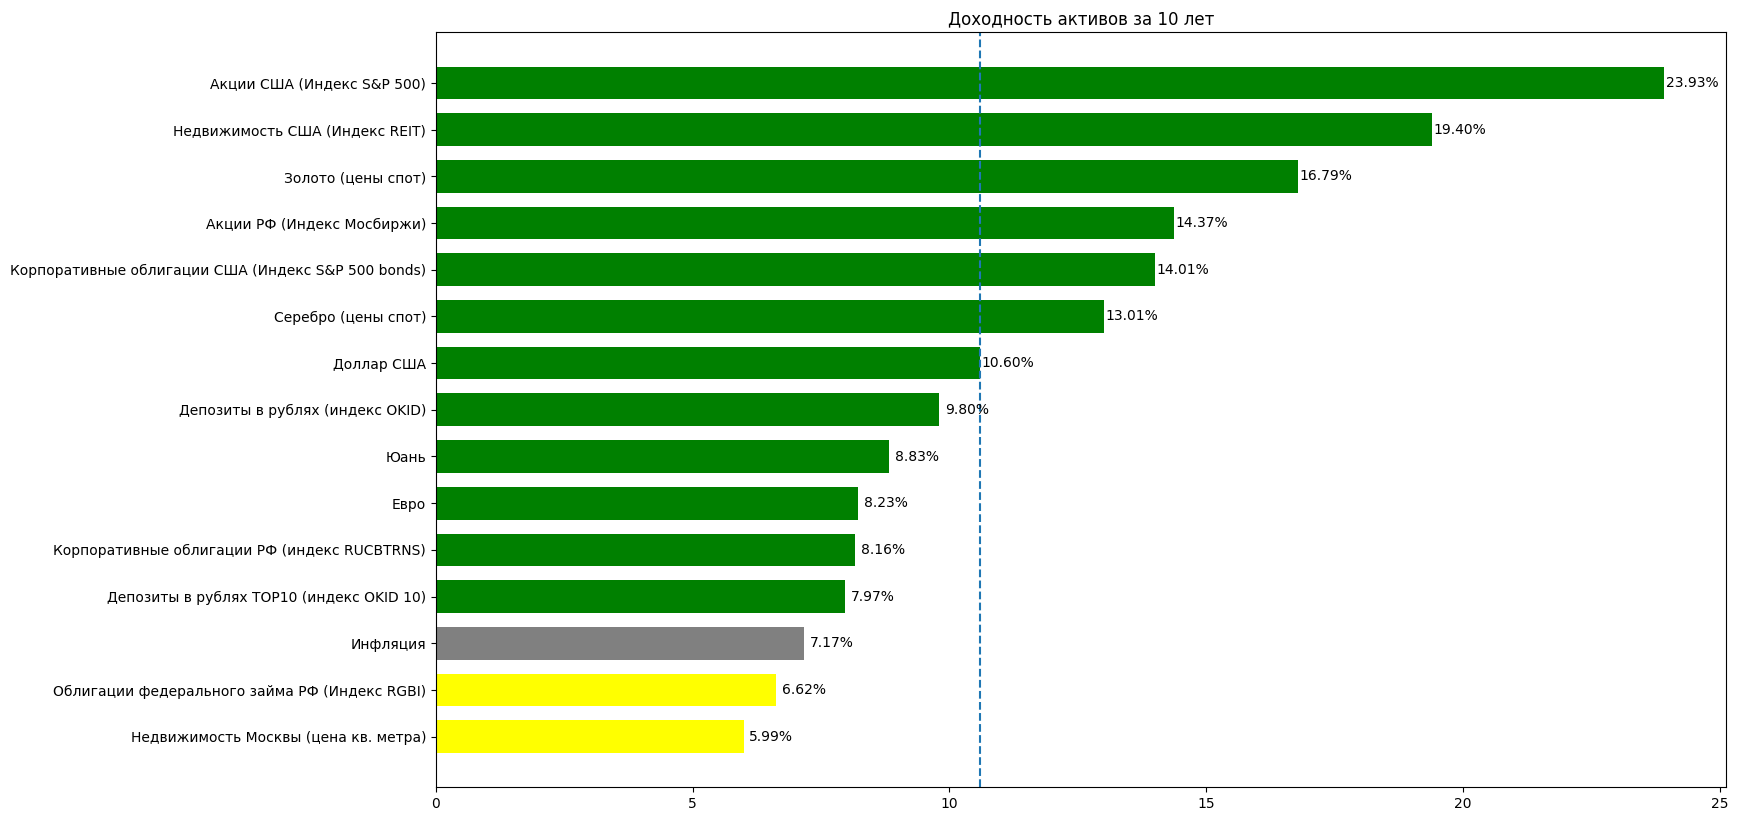

In [18]:
plot_cagr(assets10, lg_2010, 'Доходность активов за 10 лет')

## 5 лет

In [19]:
assets5 = ok.AssetList(ls_2010, first_date='2019-01', last_date='2023-12', ccy='RUB')
assets5

assets           [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2019-01
last_date                                                  2023-12
period_length                                    5 years, 0 months
inflation                                                 RUB.INFL
dtype: object

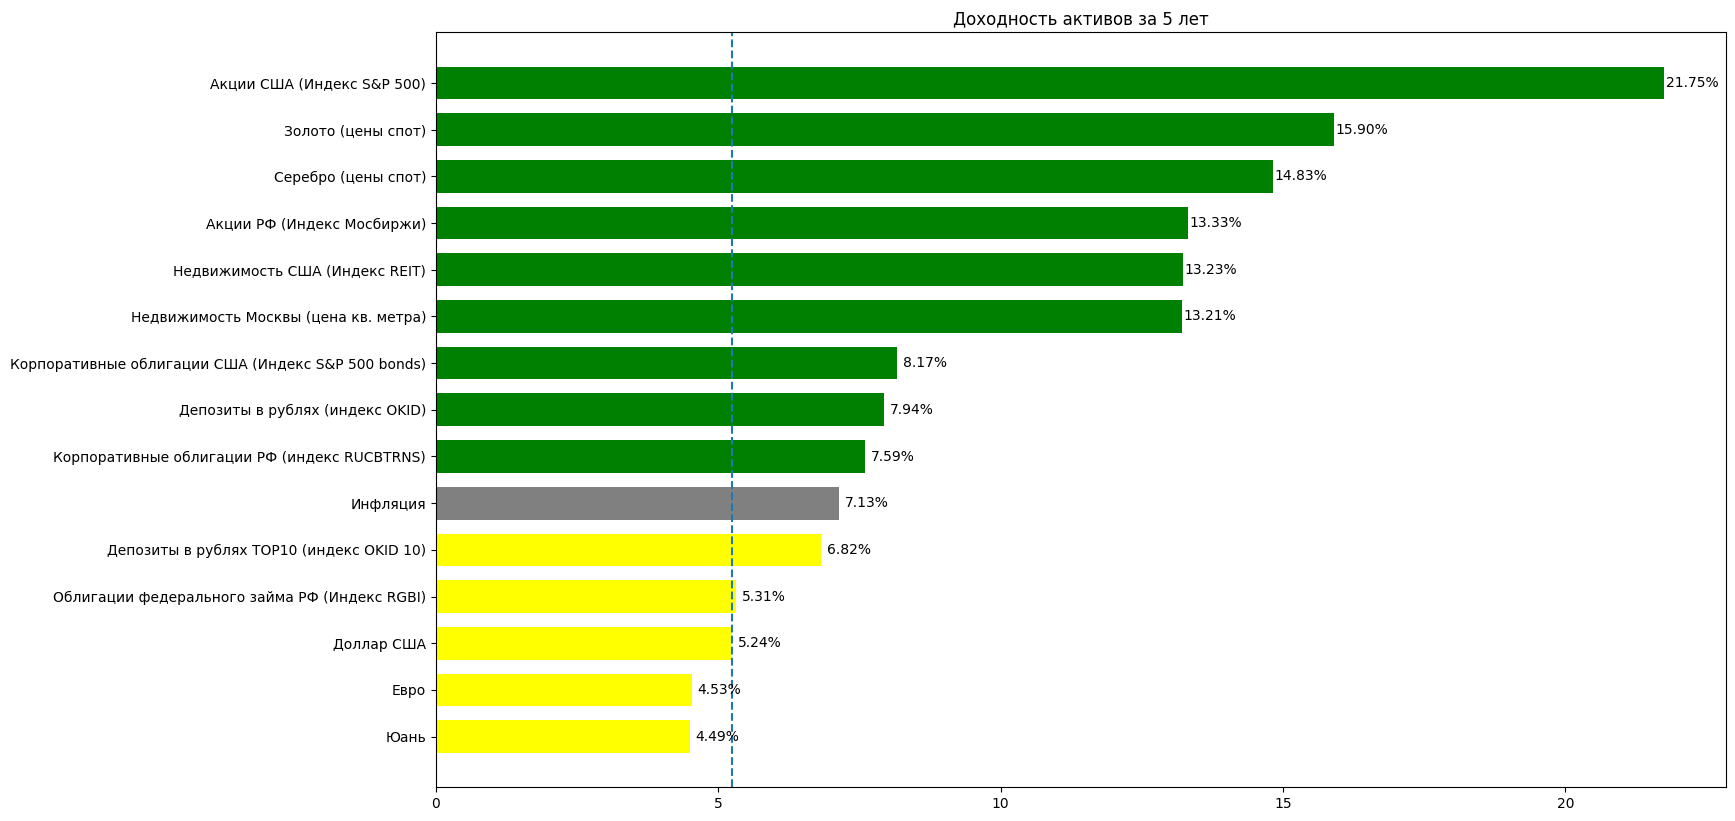

In [20]:
plot_cagr(assets5, lg_2010, 'Доходность активов за 5 лет')

In [21]:
assets5.describe([2, 3])

,property,period,RGBITR.INDX,RUCBTRNS.INDX,MCFTR.INDX,SP500TR.INDX,SP500BDT.INDX,FNER.INDX,MOW_SEC.RE,GC.COMM,SI.COMM,USDRUB.FX,EURRUB.FX,CNYRUB.FX,OKID10.INDX,OKID.INDX,inflation
0,Compound return,YTD,0.007554,0.024064,0.538714,0.609905,0.382409,0.419593,0.07018,0.451357,0.274347,0.274957,0.31095,0.270956,0.081922,0.096194,0.076087
1,CAGR,2 years,0.022237,0.058955,-0.017464,0.11725,0.056259,0.00431,0.126113,0.169636,0.114431,0.098649,0.086165,0.039015,0.081975,0.097497,0.097445
2,CAGR,3 years,-0.002242,0.039655,0.05541,0.173491,0.036264,0.127501,0.138755,0.099232,0.033668,0.066764,0.030275,0.035992,0.070751,0.084093,0.092922
3,CAGR,"5 years, 0 months",0.053131,0.07592,0.133258,0.217545,0.081698,0.13225,0.132137,0.158996,0.148296,0.052396,0.045293,0.044916,0.068195,0.079356,0.071335
4,Dividend yield,LTM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,Risk,"5 years, 0 months",0.116937,0.067332,0.292541,0.348369,0.259261,0.33165,0.060007,0.315262,0.491773,0.235815,0.249669,0.239129,0.004263,0.005289,NaN
6,CVAR,"5 years, 0 months",0.206548,0.084575,0.505114,0.368064,0.389025,0.33932,0.035639,0.279862,0.450831,0.293137,0.375313,0.313004,-0.047712,-0.057249,NaN
7,Max drawdowns,"5 years, 0 months",-0.228385,-0.09348,-0.512716,-0.48951,-0.443925,-0.480924,-0.092466,-0.436844,-0.526212,-0.39155,-0.425154,-0.418448,0.0,0.0,NaN
8,Max drawdowns dates,"5 years, 0 months",2022-02,2022-03,2022-09,2022-06,2022-06,2022-06,2020-03,2022-06,2022-06,2022-06,2022-06,2022-06,2019-01,2019-01,NaN
9,Inception date,None,2003-01,2003-01,1997-10,1988-02,1995-01,1972-01,2000-04,1975-02,1970-03,1992-08,1999-02,1992-08,2010-07,2010-07,2019-01


## 1 год

In [22]:
assets1 = ok.AssetList(ls_2020, first_date='2023-01', last_date='2023-12', ccy='RUB')
assets1

assets           [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2023-01
last_date                                                  2023-12
period_length                                    1 years, 0 months
inflation                                                 RUB.INFL
dtype: object

In [23]:
assets1.get_cagr()

RGBITR.INDX      0.007554
RUCBTRNS.INDX    0.024064
MCFTR.INDX       0.538714
SP500TR.INDX     0.609905
SP500BDT.INDX    0.382409
FNER.INDX        0.419593
MOW_SEC.RE       0.070180
GC.COMM          0.451357
SI.COMM          0.274347
USDRUB.FX        0.274957
EURRUB.FX        0.310950
CNYRUB.FX        0.270956
OKID10.INDX      0.081922
OKID.INDX        0.096194
MREDC.INDX       0.105584
RUB.INFL         0.076087
dtype: float64

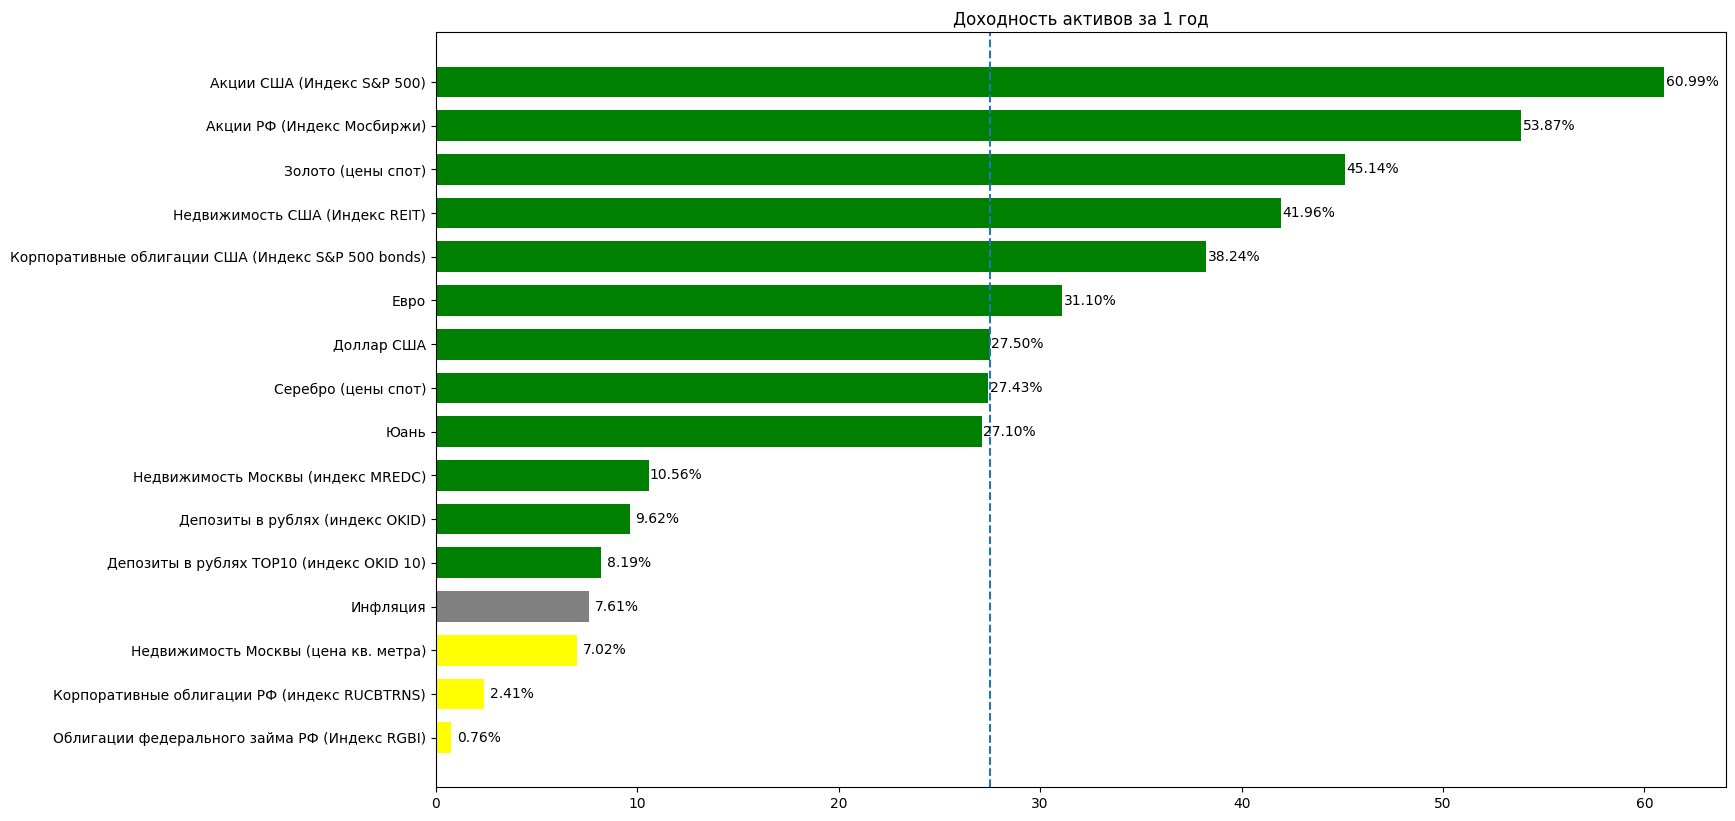

In [24]:
plot_cagr(assets1, lg_2020, 'Доходность активов за 1 год')

In [25]:
assets1.describe()

,property,period,RGBITR.INDX,RUCBTRNS.INDX,MCFTR.INDX,SP500TR.INDX,SP500BDT.INDX,FNER.INDX,MOW_SEC.RE,GC.COMM,SI.COMM,USDRUB.FX,EURRUB.FX,CNYRUB.FX,OKID10.INDX,OKID.INDX,MREDC.INDX,inflation
0,Compound return,YTD,0.007554,0.024064,0.538714,0.609905,0.382409,0.419593,0.07018,0.451357,0.274347,0.274957,0.31095,0.270956,0.081922,0.096194,0.105584,0.076087
1,CAGR,1 years,0.007554,0.024064,0.538714,0.609905,0.382409,0.419593,0.07018,0.451357,0.274347,0.274957,0.31095,0.270956,0.081922,0.096194,0.105584,0.076087
2,CAGR,5 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CAGR,10 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAGR,"1 years, 0 months",0.007554,0.024064,0.538714,0.609905,0.382409,0.419593,0.07018,0.451357,0.274347,0.274957,0.31095,0.270956,0.081922,0.096194,0.105584,0.076087
5,Dividend yield,LTM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,Risk,"1 years, 0 months",0.063129,0.033645,0.214685,0.295572,0.185867,0.31915,0.014207,0.208361,0.394386,0.185796,0.18683,0.146543,0.002013,0.00281,0.048958,NaN
7,CVAR,"1 years, 0 months",-0.007554,-0.024064,-0.538714,-0.609905,-0.382409,-0.419593,-0.07018,-0.451357,-0.274347,-0.274957,-0.31095,-0.270956,-0.081922,-0.096194,-0.105584,NaN
8,Max drawdowns,"1 years, 0 months",-0.060227,-0.035115,-0.0293,-0.093769,-0.068466,-0.124587,0.0,-0.039425,-0.100801,-0.087597,-0.06511,-0.067824,0.0,0.0,-0.0044,NaN
9,Max drawdowns dates,"1 years, 0 months",2023-10,2023-10,2023-09,2023-10,2023-10,2023-10,2023-01,2023-11,2023-10,2023-11,2023-11,2023-11,2023-01,2023-01,2023-12,NaN


## Граница эффективности


In [26]:
x = ok.EfficientFrontier(ls_2003, ccy='RUB', first_date='2004-01', last_date='2023-12')
x

symbols          [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2004-01
last_date                                                  2023-12
period_length                                   20 years, 0 months
bounds           ((0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0...
inflation                                                     None
n_points                                                        20
dtype: object

In [27]:
y = ok.EfficientFrontier(ls_2003, ccy='RUB', first_date='2003-01', last_date='2022-12')
y

symbols          [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, SP500...
currency                                                       RUB
first_date                                                 2003-01
last_date                                                  2022-12
period_length                                   20 years, 0 months
bounds           ((0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0...
inflation                                                     None
n_points                                                        20
dtype: object

In [28]:
df = x.ef_points

In [29]:
df_last_y = y.ef_points

In [34]:
short_names_2003 = {
    'RGBITR.INDX': 'ОФЗ',
    'RUCBTRNS.INDX': 'Корпоративные облигации РФ',
    'MCFTR.INDX': 'Акции РФ',
    'SP500TR.INDX': 'Акции США',
    'SP500BDT.INDX': 'Корпоративные облигации США',
    'FNER.INDX': 'REIT',
    'MOW_SEC.RE': 'Недвижимость Москвы',
    'GC.COMM': 'Золото',
    'SI.COMM': 'Серебро',
    'USDRUB.FX': 'USD',
    'EURRUB.FX': 'EUR',
    'CNYRUB.FX': 'CNY',
}

<Axes: xlabel='Риск', ylabel='Доходность'>

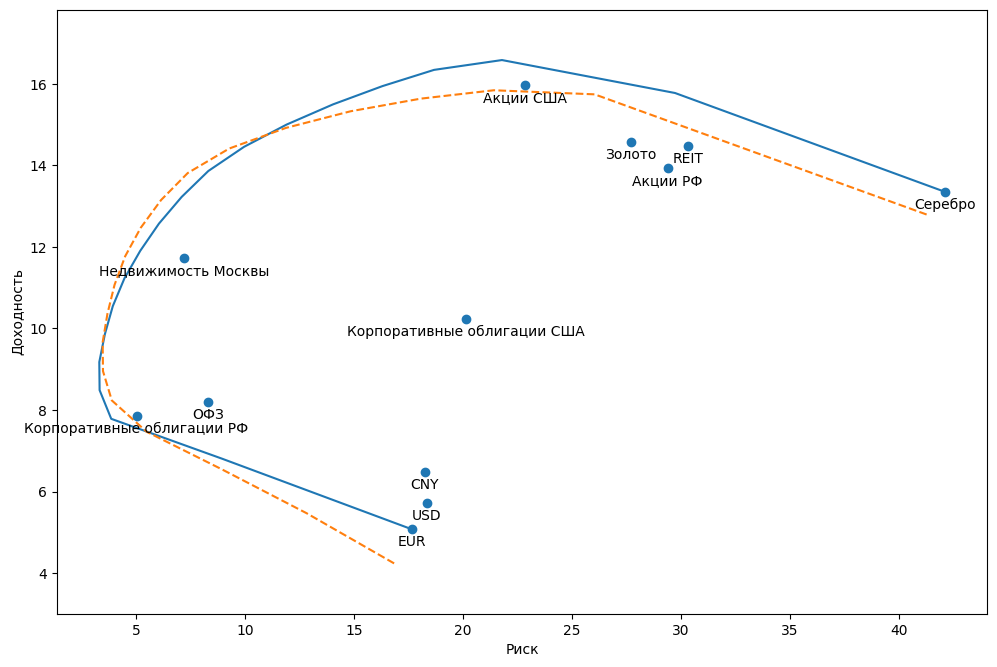

In [37]:
fig, ax = plt.subplots()

# Plotting the Efficient Frontier
ax.plot(df['Risk']*100, df['CAGR']*100)
ax.plot(df_last_y['Risk']*100, df_last_y['CAGR']*100, linestyle='dashed')

# Set X and Y labels
ax.set_xlabel('Риск')
ax.set_ylabel('Доходность')

# Plotting the assets
x.plot_assets(kind='cagr', pct_values=True, tickers=list(short_names_2003.values()), xy_text=(0, -12))

x_reb = ok.EfficientFrontierReb(ls_2003, ccy='RUB', first_date='2004-01', last_date='2023-12')
x_reb

## Граница эффективности (Ребалансировка)

y_reb = ok.EfficientFrontierReb(ls_2003, ccy='RUB', first_date='2003-01', last_date='2022-12')
y_reb

df_reb = x_reb.ef_points

df_last_y_reb = y_reb.ef_points

fig, ax = plt.subplots()

# Plotting the Efficient Frontier
ax.plot(df_reb['Risk']*100, df_reb['CAGR']*100)
ax.plot(df_last_y_reb['Risk']*100, df_last_y_reb['CAGR']*100, linestyle='dashed')

# Set X and Y labels
ax.set_xlabel('Риск')
ax.set_ylabel('Доходность')

# Plotting the assets
x_reb.plot_assets(kind='cagr', pct_values=True, tickers=list(short_names_2003.values()))